This model generates the dose profile from an arbitrary activation profile. It is trained on patient-specific data from a set of 948 pencil beams.

In [1]:
### ONLY FOR GOOGLE COLAB
# Mounting google drive
# from google.colab import drive
# drive.mount('/content/drive')
# import os
# os.chdir("drive/MyDrive/Colab Notebooks/prototwin/deep-learning-dose-activity-dictionary")
# !pip install livelossplot
###

from train_model import train
from test_model import test
from utils import set_seed, DoseActivityDataset, plot_slices, plot_ddp
seed = 42
set_seed(seed)
import torch
from torch.utils.data import DataLoader
from torchvision.transforms import Compose, Normalize#, RandAugment, RandomRotation, GaussianBlur, RandomHorizontalFlip, RandomVerticalFlip
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# Creating the dataset
input_dir = "data/dataset_1/input"
output_dir = "data/dataset_1/output"

# Statistics of the dataset (previously found for the entire Prostate dataset)
mean_input = 0.002942
std_input = 0.036942
max_input = 1.977781
min_input = 0.0

mean_output = 0.00000057475
std_output = 0.00000662656
max_output = 0.00060621166
min_output = 0.0


# Transformations
input_transform = Compose([
    # GaussianBlur(kernel_size=3, sigma=1.0),
    Normalize(mean_input, std_input)
])

output_transform = Compose([
    Normalize(mean_output, std_output)
])

# joint_transform = Compose([
#     RandomRotation(5),
#     RandAugment(magnitude=2),
#     RandomHorizontalFlip(),
#     RandomVerticalFlip()
# ])

# Create dataset applying the transforms
dataset = DoseActivityDataset(input_dir=input_dir, output_dir=output_dir,
                              input_transform=input_transform, output_transform=output_transform,
                              num_samples=948)

# Split dataset into 70% training, 20% validation, 10% testing
train_size = int(0.7 * len(dataset))
val_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

In [ ]:
# Create DataLoaders for training
batch_size = 8  # Largest batch size without running out of memory
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

In [ ]:
from models.models import UNetV5
# Create the model
model = UNetV5().to(device)

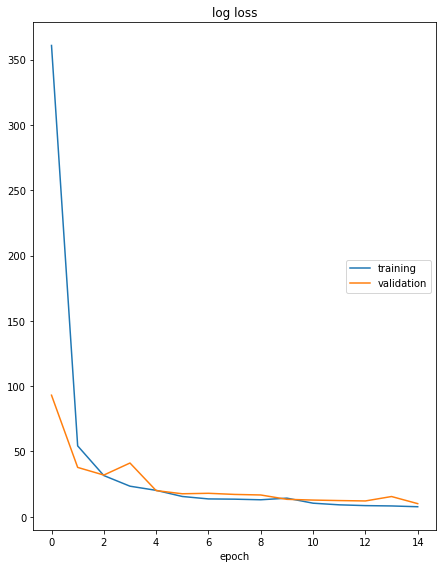

log loss
	training         	 (min:    7.636, max:  360.844, cur:    7.636)
	validation       	 (min:   10.005, max:   93.044, cur:   10.005)
Training time: 1603.120141029358 seconds


In [ ]:
model_dir = 'models/trained-models/unet-v11.pth'
timing_dir = 'models/training-times/training-time-unet-v11.txt'
n_epochs = 15
# trained_model = train(model, train_loader, val_loader, epochs=n_epochs,
#                       model_dir=model_dir, timing_dir=timing_dir)

In [ ]:
# Loading the trained model
model_dir = "models/trained-models/unet-v11.pth"
trained_model = torch.load(model_dir, map_location=torch.device(device))

/home/petgfn/PabloJr/prototwin/deep-learning-dose-activity-dictionary/utils.py:285: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


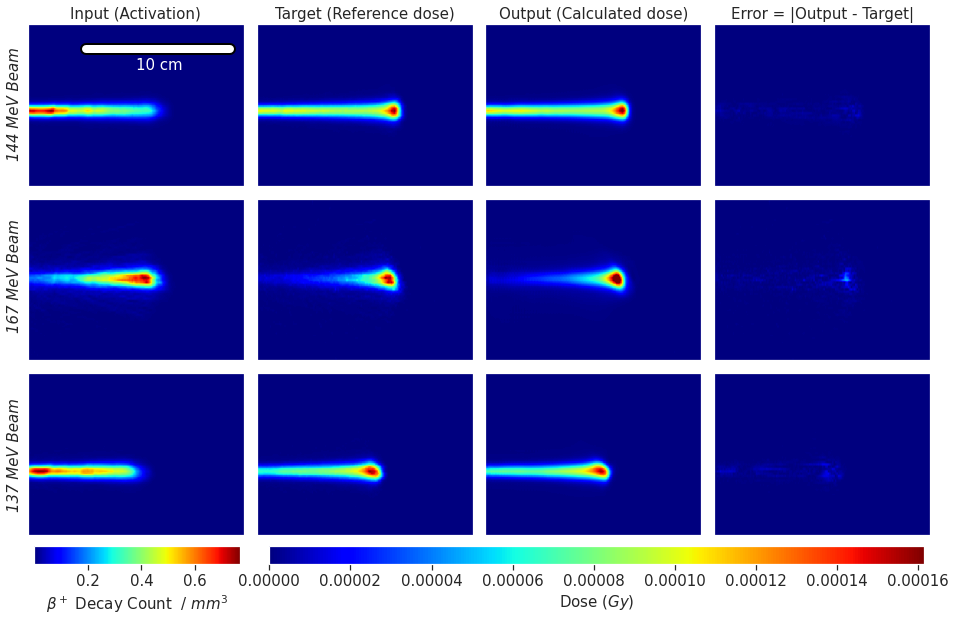

In [ ]:
# Plotting slices of the dose
plot_slices(trained_model, val_loader, device, mean_input=mean_input, std_input=std_input,
            mean_output=mean_output, std_output=std_output,
            save_plot_dir = "images/unet-v11-sample.png")

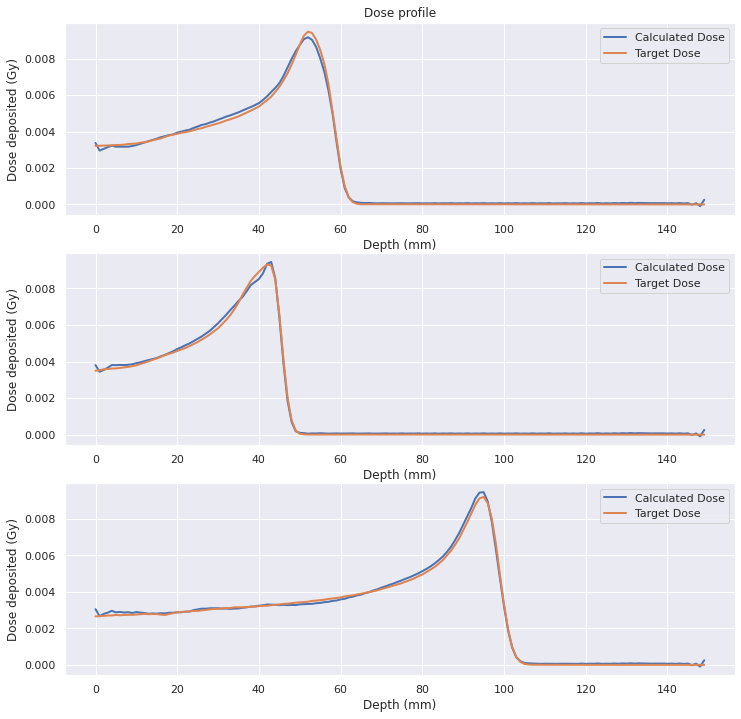

In [ ]:
# Plotting the dose-depth profiles
save_plot_dir = "images/unet-v11-ddp.png"
plot_ddp(trained_model, train_loader, device, mean_output=mean_output,
         std_output=std_output, save_plot_dir = save_plot_dir)

In [ ]:
results_dir = 'models/test-results/unet-v11-results.txt'
test(trained_model, test_loader, device, results_dir=results_dir)

100%|██████████| 12/12 [00:10<00:00,  1.19it/s]

Relative Error: 0.0036794112529605627 +- 0.1854167878627777
R90: 0.2613448202610016 +- 0.914718508720398
R90 squared: 0.904913604259491
R50: 0.07324671745300293 +- 0.4799581468105316
R50 squared: 0.23569808900356293
R10: 0.13563816249370575 +- 0.613965630531311
R10 squared: 0.3953075408935547
L2 Loss: 0.0045183985494077206 +- 0.0009734455379657447
